# Install libraries

In [1]:
!pip3 install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

## Data down

- 데이터 다운로드
  - KorQuAD 1.0 데이터 (https://korquad.github.io/KorQuad%201.0/) 에서 Training set, Dev set 다운로드 후 Google Drive에 업로드
- 데이터 구성
  - 1,560 개의 Wikipedia article에 대해 10,645 건의 문단과 66,181 개의 질의응답 쌍
  - Training set 60,407 개, Dev set 5,774 개의 질의응답쌍


In [3]:
import os
import json
import numpy
import matplotlib.pyplot as plt

from transformers import ElectraModel, ElectraTokenizer

In [4]:
DATAPATH = '/content/drive/MyDrive/NLP Dataset/KorQuAD 1.0 Dataset'
filenames = [x for x in os.listdir (DATAPATH) if x.endswith('json')]
filenames.sort()
filenames

['KorQuAD_v1.0_dev.json', 'KorQuAD_v1.0_train.json']

In [5]:
file = filenames[1]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

data[0]

{'paragraphs': [{'qas': [{'answers': [{'text': '교향곡', 'answer_start': 54}],
     'id': '6566495-0-0',
     'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'},
    {'answers': [{'text': '1악장', 'answer_start': 421}],
     'id': '6566495-0-1',
     'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?'},
    {'answers': [{'text': '베토벤의 교향곡 9번', 'answer_start': 194}],
     'id': '6566495-0-2',
     'question': '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?'},
    {'answers': [{'text': '파우스트', 'answer_start': 15}],
     'id': '6566518-0-0',
     'question': '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?'},
    {'answers': [{'text': '합창교향곡', 'answer_start': 354}],
     'id': '6566518-0-1',
     'question': '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?'},
    {'answers': [{'text': '1839', 'answer_start': 0}],
     'id': '5917067-0-0',
     'question': '바그너가 파우스트를 처음으로 읽은 년도는?'},
    {'answers': [{'text': '파리', 'answer_start': 410}],
     'id': '5917067-0-1',
     'question': '바그너가 처음 교향곡 작곡을 한 장소는?'},
    {'answers': [{'text': '드레스덴', 'answer_sta

## Model & Tokenizer load

In [6]:
# KoELECTRA-Base-v3
model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

In [8]:
cont_lens = []
q_lens = []
a_lens = []

para_num = 0
cont_num = 0
q_num = 0

cont_unk_num = 0
q_unk_num = 0
a_unk_num = 0

for x in range(len(data)):
  paragraphs = data[x]['paragraphs']
  para_num += 1

  ## context
  for para in paragraphs:
    context = para['context']
    cont_num += 1
    con_tokens = tokenizer.tokenize(context)
    cont_lens.append(len(con_tokens))

    for t in con_tokens:
      if t == '[UNK]':
        cont_unk_num += 1

    ## qas
    qas = para['qas']
    for qa in qas:
      question = qa['question']
      answer = qa['answers'][0]['text']
      q_num += 1
      q_tokens = tokenizer.tokenize(question)
      a_tokens = tokenizer.tokenize(answer)
      q_lens.append(len(q_tokens))
      a_lens.append(len(a_tokens))

      for t in q_tokens:
        if t == '[UNK]':
          q_unk_num += 1

      for t in a_tokens:
        if t == '[UNK]':
          a_unk_num += 1

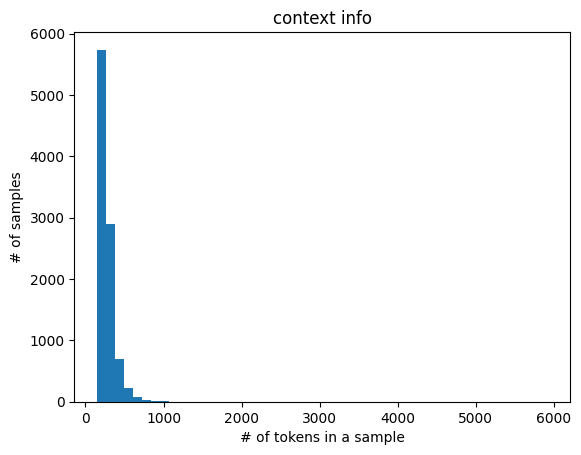

--------------- context info ---------------
# of paragraphs = 1420 | # of contexts = 9681
min = 147 | mean = 274.51 | median = 245.00 | max = 5925
# of [UNK] tokens = 2655 | % of [UNK] tokens = 0.10%


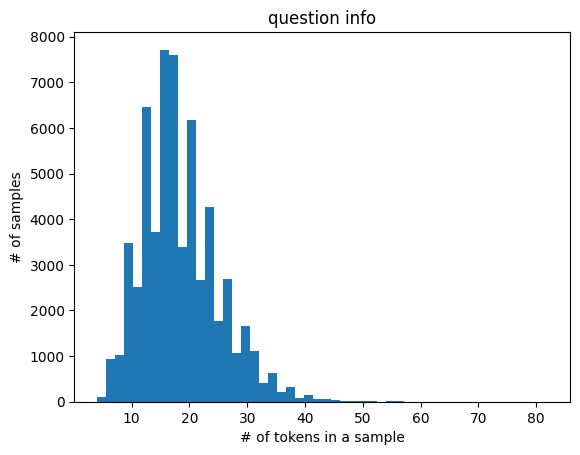

--------------- question info ---------------
# of questions = 60407
min = 4 | mean = 18.46 | median = 18.00 | max = 82
# of [UNK] tokens = 110 | % of [UNK] tokens = 0.01%


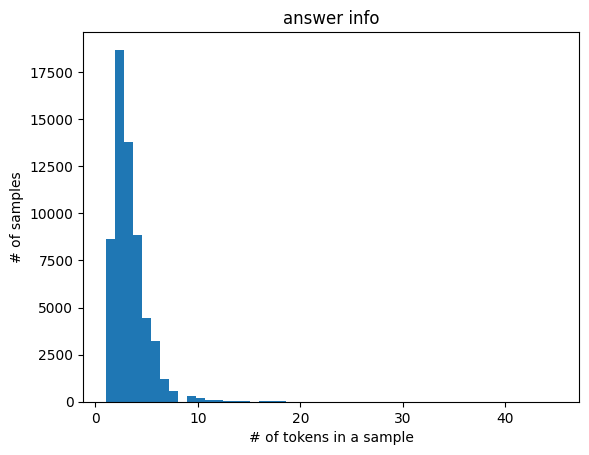

--------------- answer info ---------------
# of answers = 60407
min = 1 | mean = 3.12 | median = 3.00 | max = 45
# of [UNK] tokens = 109 | % of [UNK] tokens = 0.06%


In [9]:
## context
min = numpy.min(cont_lens)
mean = numpy.mean(cont_lens)
median = numpy.median(cont_lens)
max = numpy.max(cont_lens)

plt.hist(cont_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('context info')
plt.show()

print('--------------- context info ---------------')
print('# of paragraphs = {} | # of contexts = {}'.format(para_num, cont_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(cont_unk_num, 100*(cont_unk_num/sum(cont_lens))))

## question
min = numpy.min(q_lens)
mean = numpy.mean(q_lens)
median = numpy.median(q_lens)
max = numpy.max(q_lens)

plt.hist(q_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('question info')
plt.show()

print('--------------- question info ---------------')
print('# of questions = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(q_unk_num, 100*(q_unk_num/sum(q_lens))))

## answer
min = numpy.min(a_lens)
mean = numpy.mean(a_lens)
median = numpy.median(a_lens)
max = numpy.max(a_lens)

plt.hist(a_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('answer info')
plt.show()

print('--------------- answer info ---------------')
print('# of answers = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(a_unk_num, 100*(a_unk_num/sum(a_lens))))